In [703]:
from __future__ import print_function, division
import requests
from bs4 import BeautifulSoup
import pandas as pd
from collections import defaultdict
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cross_validation import KFold
from sklearn.linear_model import ElasticNet
from sklearn import feature_selection as f_select
import re
%matplotlib inline

In [704]:
pitching = pd.read_csv('Pitchingdata.csv')
batting = pd.read_csv('battersdata.csv')
salaries = pd.read_csv('salariesdata.csv')

In [705]:
salaries = salaries.drop(["Pos'n", "MLS"], axis=1)

In [706]:
salaries

,Player,2017
0,"Kershaw, Clayton","$35,571,429"
1,"Greinke, Zack","$34,000,000"
2,"Price, David","$30,000,000"
3,"Hamilton, Josh","$28,410,000"
4,"Heyward, Jason","$28,166,667"
5,"Cabrera, Miguel","$28,000,000"
6,"Verlander, Justin","$28,000,000"
7,"Hernandez, Felix","$26,857,143"
8,"Pujols, Albert","$26,000,000"
9,"Sabathia, CC","$25,000,000"


In [707]:
#lets remove all of those nasty characters from our names so we can merge easily
from string import printable

batting['Name'] = batting['Name'].apply(lambda x: x.split('*',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: x.split('#',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: x.split('\\',1)[0])
batting['Name'] = batting['Name'].apply(lambda x: re.sub("[^{}]+".format(printable), " ", x))
batting['Name'] = batting['Name'].apply(lambda x: x.split(' ',1)[-1] + ',' + ' ' + x.split(' ',1)[0])

In [708]:
batting['Name']

0             Abad, Fernando
1                Abreu, Jose
2          Adames, Cristhian
3              Adams, Austin
4                Adams, Lane
5                Adams, Matt
6                Adams, Matt
7                Adams, Matt
8                Adduci, Jim
9               Adleman, Tim
10           Adrianza, Ehire
11            Aguilar, Jesus
12               Ahmed, Nick
13            Albers, Andrew
14              Albers, Matt
15             Albies, Ozzie
16          Alburquerque, Al
17          Alburquerque, Al
18      Alcantara, Arismendy
19          Alcantara, Sandy
20          Alexander, Scott
21             Alfaro, Jorge
22           Alford, Anthony
23               Allen, Cody
24               Allen, Greg
25          Almonte, Abraham
26            Almora, Albert
27            Alonso, Yonder
28            Alonso, Yonder
29            Alonso, Yonder
                ...         
1424            Wong, Kolten
1425              Wood, Alex
1426             Wood, Blake
1427          

In [709]:
#Lets do the same thing with the pitching data
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('*',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('#',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: x.split('\\',1)[0])
pitching['Name'] = pitching['Name'].apply(lambda x: re.sub("[^{}]+".format(printable), " ", x))
pitching['Name'] = pitching['Name'].apply(lambda x: x.split(' ',1)[-1] + ',' + ' ' + x.split(' ',1)[0])


In [710]:
pitching['Name']

0            Abad, Fernando
1             Adams, Austin
2              Adleman, Tim
3            Albers, Andrew
4              Albers, Matt
5          Alburquerque, Al
6          Alburquerque, Al
7          Alburquerque, Al
8           Alcantara, Raul
9          Alcantara, Sandy
10        Alcantara, Victor
11         Alexander, Scott
12              Allen, Cody
13          Almonte, Miguel
14           Altavilla, Dan
15           Alvarado, Jose
16           Alvarez, Dario
17       Alvarez, Henderson
18            Alvarez, Jose
19          Anderson, Brett
20          Anderson, Brett
21          Anderson, Brett
22          Anderson, Chase
23           Anderson, Drew
24          Anderson, Tyler
25           Andriese, Matt
26          Aoki, Norichika
27           Aquino, Jayson
28            Arano, Victor
29            Archer, Chris
               ...         
892            Winkler, Dan
893            Wisler, Matt
894          Wittgren, Nick
895    Wojciechowski, Asher
896              Woo

In [711]:
#narrow down our sample to only players with more than 200 at bats this year
batting2 = batting[batting['AB'] >= 200]

In [712]:
#narrow down our sample to only players with more than 30 games played this year
pitching2 = pitching[pitching['G'] >= 30]

In [713]:
salaries.rename(columns={'Player':'Name', '2017' : 'Salary'},inplace = True)

In [714]:
def money_to_int(moneystring):
    moneystring = moneystring.replace('$', '').replace(',', '').replace(' ','')
    return int(moneystring)

In [715]:
salaries['Salary'] = salaries['Salary'].apply(lambda x: money_to_int(x))

In [716]:
#lets merge our salaries dataframe with our pitching dataframe 

pitchdf = pd.merge(salaries, pitching2, on=['Name'])

In [717]:
batdf = pd.merge(salaries, batting2, on=['Name'])

In [718]:
batdf.columns[30]

'Pos\xa0Summary'

In [719]:
batdf.drop_duplicates('Name', inplace = True)

In [720]:
batdf = batdf.drop(['Rk', 'Tm', 'Lg', 'Pos\xa0Summary'],1)

In [721]:
pitchdf.drop_duplicates('Name', inplace = True)

In [722]:
pitchdf = pitchdf.drop(['Rk', 'Tm', 'Lg'],1)

In [723]:
pitchdf.corr()

,Salary,Age,W,L,W-L%,ERA,G,GS,GF,CG,...,WP,BF,ERA+,FIP,WHIP,H9,HR9,BB9,SO9,SO/W
Salary,1.000000,0.373189,0.433273,0.389039,0.016402,0.005547,-0.350293,0.473351,-0.141373,0.346680,...,0.237389,0.452400,0.054991,-0.026405,-0.133880,-0.016048,0.118214,-0.216016,0.050844,0.217138
Age,0.373189,1.000000,-0.068667,-0.008345,-0.059979,0.052522,0.068180,-0.027509,-0.029084,0.051132,...,-0.048968,-0.038581,-0.033776,0.075806,-0.035610,0.005421,0.085880,-0.068982,-0.077239,0.027618
W,0.433273,-0.068667,1.000000,0.611439,0.290878,-0.068522,-0.554933,0.835978,-0.427723,0.462779,...,0.429261,0.855482,0.005494,-0.003154,-0.112993,0.017639,0.042167,-0.228140,-0.115141,0.063490
L,0.389039,-0.008345,0.611439,1.000000,-0.371310,0.276107,-0.557348,0.830938,-0.362769,0.380076,...,0.404368,0.842886,-0.292415,0.252901,0.202024,0.311484,0.219085,-0.107272,-0.296271,-0.119242
W-L%,0.016402,-0.059979,0.290878,-0.371310,1.000000,-0.308612,-0.011804,-0.023138,-0.075982,0.033437,...,-0.007516,-0.035562,0.307650,-0.241642,-0.318840,-0.308357,-0.158914,-0.106730,0.179857,0.221614
ERA,0.005547,0.052522,-0.068522,0.276107,-0.308612,1.000000,-0.414439,0.186806,-0.261435,-0.014462,...,0.078326,0.113151,-0.882946,0.740060,0.769089,0.736778,0.639614,0.271183,-0.393171,-0.444568
G,-0.350293,0.068180,-0.554933,-0.557348,-0.011804,-0.414439,1.000000,-0.753535,0.552777,-0.336870,...,-0.273227,-0.640132,0.391566,-0.374471,-0.268073,-0.360323,-0.368468,0.061512,0.283647,0.133892
GS,0.473351,-0.027509,0.835978,0.830938,-0.023138,0.186806,-0.753535,1.000000,-0.545358,0.472028,...,0.437742,0.976892,-0.219684,0.212558,0.097568,0.235137,0.209534,-0.178891,-0.279802,-0.055188
GF,-0.141373,-0.029084,-0.427723,-0.362769,-0.075982,-0.261435,0.552777,-0.545358,1.000000,-0.249362,...,-0.145493,-0.490541,0.326459,-0.303616,-0.229860,-0.284794,-0.212156,0.015802,0.329671,0.215919
CG,0.346680,0.051132,0.462779,0.380076,0.033437,-0.014462,-0.336870,0.472028,-0.249362,1.000000,...,0.301101,0.494042,-0.026454,0.029145,-0.064509,0.049426,0.078479,-0.190725,-0.100535,0.061236


In [724]:
batdf.corr()

,Salary,Age,G,PA,AB,R,H,2B,3B,HR,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
Salary,1.000000,0.614947,0.084252,0.224861,0.204336,0.197061,0.205408,0.166697,-0.090181,0.136706,...,0.176834,0.092653,0.132480,0.134215,0.190245,0.293039,0.012459,-0.167252,0.167397,0.205933
Age,0.614947,1.000000,-0.121059,-0.079795,-0.095957,-0.114183,-0.118144,-0.086047,-0.211711,-0.097755,...,-0.010974,-0.108292,-0.081726,-0.082453,-0.132524,0.083086,0.053219,-0.083489,0.027551,-0.091666
G,0.084252,-0.121059,1.000000,0.901057,0.895695,0.773676,0.815214,0.687224,0.289284,0.561015,...,0.240773,0.299858,0.305253,0.297578,0.805556,0.494092,0.214022,0.020452,0.401680,0.352083
PA,0.224861,-0.079795,0.901057,1.000000,0.990169,0.891514,0.932882,0.774386,0.315172,0.643876,...,0.352175,0.402451,0.420311,0.420445,0.920145,0.553773,0.252023,-0.085829,0.438844,0.396347
AB,0.204336,-0.095957,0.895695,0.990169,1.000000,0.859470,0.943257,0.774161,0.328446,0.604791,...,0.266863,0.365750,0.362200,0.361389,0.909209,0.569031,0.208646,-0.063409,0.425260,0.342883
R,0.197061,-0.114183,0.773676,0.891514,0.859470,1.000000,0.877092,0.732575,0.382568,0.708917,...,0.546879,0.594472,0.630677,0.621923,0.917027,0.420172,0.274586,-0.124862,0.322862,0.426373
H,0.205408,-0.118144,0.815214,0.932882,0.943257,0.877092,1.000000,0.806804,0.363577,0.568290,...,0.466351,0.501145,0.533806,0.535250,0.930540,0.574197,0.204043,-0.068112,0.416846,0.385592
2B,0.166697,-0.086047,0.687224,0.774386,0.774161,0.732575,0.806804,1.000000,0.206578,0.481805,...,0.387737,0.490815,0.497149,0.483434,0.801476,0.459309,0.167937,-0.120831,0.399989,0.366652
3B,-0.090181,-0.211711,0.289284,0.315172,0.328446,0.382568,0.363577,0.206578,1.000000,0.006550,...,0.154499,0.092161,0.123884,0.103134,0.290091,-0.081762,0.087896,0.177304,0.007000,0.088781
HR,0.136706,-0.097755,0.561015,0.643876,0.604791,0.708917,0.568290,0.481805,0.006550,1.000000,...,0.366841,0.801743,0.712690,0.683121,0.821460,0.398849,0.193034,-0.316122,0.280360,0.417200


In [732]:

est=LinearRegression()
x = batdf.drop(['Salary','Name'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = batdf['Salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
sig_cols
    

['Age',
 'PA',
 'AB',
 'R',
 'H',
 '2B',
 'HR',
 'RBI',
 'BB',
 'OBP',
 'TB',
 'GDP',
 'SH',
 'SF',
 'IBB']

In [736]:
x = batdf[sig_cols]
y = batdf['Salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))

print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
lr.coef_


Fit score (R^2) is: 0.508518
Fit intercept is: -30240470.354932
Mean of the target value is: 6247631.760274


array([ 1148907.71476162,  -130749.92805216,   128979.82071879,
          47275.38479783,   109114.4910306 ,    11672.05658324,
         145978.65180762,    16074.14266138,   146493.71336068,
       -4833597.82487225,   -78635.48687298,    87942.0571541 ,
        -171889.12139191,   218693.75770972,   338390.73134836])

In [745]:
pitchdf.columns[3:]

Index(['W', 'L', 'W-L%', 'ERA', 'G', 'GS', 'GF', 'CG', 'SHO', 'SV', 'IP', 'H',
       'R', 'ER', 'HR', 'BB', 'IBB', 'SO', 'HBP', 'BK', 'WP', 'BF', 'ERA+',
       'FIP', 'WHIP', 'H9', 'HR9', 'BB9', 'SO9', 'SO/W'],
      dtype='object')

In [746]:
pitchdf = pitchdf.dropna()
est=LinearRegression()
x = pitchdf.drop(['Salary','Name'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = pitchdf['Salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
sig_cols
    

['Age',
 'W',
 'L',
 'G',
 'GS',
 'GF',
 'CG',
 'IP',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'SO',
 'HBP',
 'WP',
 'BF',
 'BB9']

In [747]:
x = pitchdf[sig_cols]
y = pitchdf['Salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))

print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
lr.coef_



Fit score (R^2) is: 0.540083
Fit intercept is: -14491370.826090
Mean of the target value is: 4196622.720524


array([ 535961.57930574,  177575.17925804,  143010.64573482,
         17374.8327902 ,  456133.93305528,   63430.94249095,
        367182.57148032,  163422.1404862 ,  -34647.61696283,
        283739.25041833, -233273.02465161,  148212.28269767,
       -145406.55183018,   42412.40397601, -107763.13144539,
         -9258.67246023,  -58022.03500489,  824926.59419108])

In [748]:
#These are not the best fits so lets try again with logSalary
pitchdf['log_salary'] = np.log(pitchdf.Salary)
batdf['log_salary'] = np.log(batdf.Salary)

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [757]:
est=LinearRegression()
x = batdf.drop(['Salary','Name', 'log_salary'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = batdf['log_salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
bsig_cols = sig_cols
bsig_cols

['Age',
 'PA',
 'AB',
 'R',
 'H',
 '2B',
 'HR',
 'RBI',
 'BB',
 'OBP',
 'SLG',
 'OPS',
 'OPS+',
 'TB',
 'GDP',
 'SH',
 'SF',
 'IBB']

In [758]:
x = batdf[bsig_cols]
y = batdf['log_salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))

print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
lr.coef_

Fit score (R^2) is: 0.613908
Fit intercept is: 8.876635
Mean of the target value is: 14.892948


array([  2.57719107e-01,  -1.06527235e-02,   7.30793111e-03,
         1.65874466e-02,   1.92611858e-02,   1.16853223e-04,
         9.27130765e-03,  -1.63836819e-03,   1.24515844e-02,
         8.51931933e+01,   8.87191357e+01,  -9.18589152e+01,
         1.07746175e-02,  -5.95454755e-03,   1.84647914e-02,
        -7.91685744e-02,   5.52435603e-02,   4.89932839e-02])

In [760]:
pitchdf = pitchdf.dropna()
est=LinearRegression()
x = pitchdf.drop(['Salary','Name', 'log_salary'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)
y = pitchdf['log_salary']
all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
psig_cols = sig_cols
psig_cols

['Age',
 'W',
 'L',
 'G',
 'GS',
 'CG',
 'SHO',
 'IP',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'SO',
 'HBP',
 'WP',
 'BF',
 'BB9',
 'SO/W']

In [761]:
x = pitchdf[psig_cols]
y = pitchdf['log_salary']
lr = LinearRegression()
lr.fit(x,y)

# Fit the model to the full dataset


print('Fit score (R^2) is: %f'%lr.score(x,y))

print('Fit intercept is: %f'%lr.intercept_)
print('Mean of the target value is: %f'%y.mean())
lr.coef_

Fit score (R^2) is: 0.579146
Fit intercept is: 8.250927
Mean of the target value is: 14.554615


array([ 0.1735328 ,  0.02946675,  0.08787085,  0.01123756,  0.10010255,
        0.06835571,  0.01093926,  0.02802533,  0.00083799,  0.03405293,
       -0.02868573,  0.01846021, -0.01275471,  0.00668567, -0.02348416,
        0.00845593, -0.01340478,  0.19124579,  0.13580547])

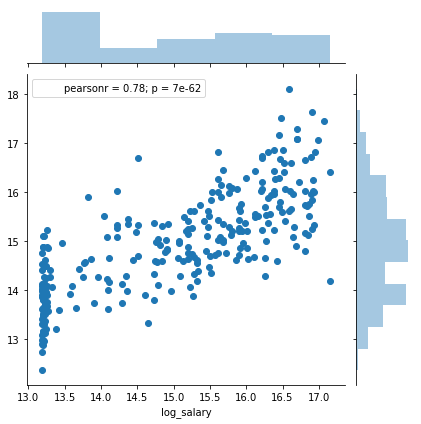

In [764]:
x = batdf[bsig_cols]
y = batdf['log_salary']
lr = LinearRegression()
fit = lr.fit(x,y)
y_predicted = fit.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
#plt.title('Predictions vs. Actual outcome')
#plt.xlabel('Actual outcome')
#plt.ylabel('Predicted outcome')

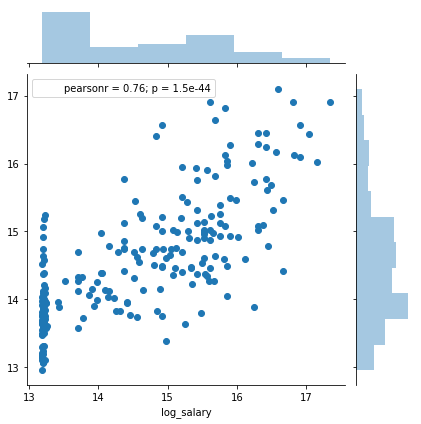

In [765]:
x = pitchdf[psig_cols]
y = pitchdf['log_salary']
lr = LinearRegression()
fit = lr.fit(x,y)
y_predicted = fit.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
#plt.title('Predictions vs. Actual outcome')
#plt.xlabel('Actual outcome')
#plt.ylabel('Predicted outcome')

In [653]:
# Define the model
lm3 = smf.ols('log_salary ~ Age + W + GS + ERA + CG + SV + BB + BK', data=pitchdf)

# Fit the model
fit3 = lm3.fit()
# Print summary statistics of the model's performance
fit3.summary()
#As we can see this is infact a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.526
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     30.97
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           2.39e-32
Time:                        11:51:23   Log-Likelihood:                -283.38
No. Observations:                 232   AIC:                             584.8
Df Residuals:                     223   BIC:                             615.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.2889      0.544     17.072      0.000       8.217      10.361
Age            0.1729      0.015     11.540      0.000       0.143       0.202
W              0.0136      0.026      0.523      0.601      -0.038       0.065
GS             0.0552      0.012      4.656      0.000       0.032       0.079
ERA            0.0083      0.056      0.149      0.882      -0.102       0.118
CG             0.1070      0.128      0.838      0.403      -0.145       0.358
SV             0.0247      0.006      3.946      0.000       0.012       0.037
BB            -0.0138      0.007     -2.120      0.035      -0.027      -0.001
BK            -0.1989      0.099     -2.009      0.046      -0.394      -0.004
==============================================================================
Omnibus:                        3.188   Durbin-Watson:                   1.007
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.337
Skew:                          -0.075   Prob(JB):                        0.311
Kurtosis:                       2.532   Cond. No.                         469.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [654]:
# Define the model
lm4 = smf.ols('log_salary ~ Age + G + PA + RBI + SO', data=batdf)

# Fit the model
fit4 = lm4.fit()
# Print summary statistics of the model's performance
fit4.summary()
#again we can see that this is a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.623
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     94.45
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           1.80e-58
Time:                        11:51:24   Log-Likelihood:                -358.58
No. Observations:                 292   AIC:                             729.2
Df Residuals:                     286   BIC:                             751.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6834      0.501     15.342      0.000       6.698       8.669
Age            0.2423      0.013     18.098      0.000       0.216       0.269
G             -0.0228      0.005     -4.989      0.000      -0.032      -0.014
PA             0.0070      0.001      7.058      0.000       0.005       0.009
RBI            0.0064      0.003      1.937      0.054      -0.000       0.013
SO            -0.0066      0.002     -3.664      0.000      -0.010      -0.003
==============================================================================
Omnibus:                        0.490   Durbin-Watson:                   1.071
Prob(Omnibus):                  0.783   Jarque-Bera (JB):                0.620
Skew:                           0.057   Prob(JB):                        0.733
Kurtosis:                       2.805   Cond. No.                     5.42e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [655]:
batdf.columns


Index(['Name', 'Salary', 'Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB',
       'GDP', 'HBP', 'SH', 'SF', 'IBB', 'log_salary'],
      dtype='object')

In [661]:
# Define the model
y = batdf['log_salary']
X = batdf.drop(['log_salary', 'Salary','Name'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rcv = RidgeCV(cv=10)
# Fit the model
rfit = rcv.fit(X,y)
# Print summary statistics of the model's performance
rfit.score(X_test, y_test)


#again we can see that this is a better fit.

0.63143174634824295

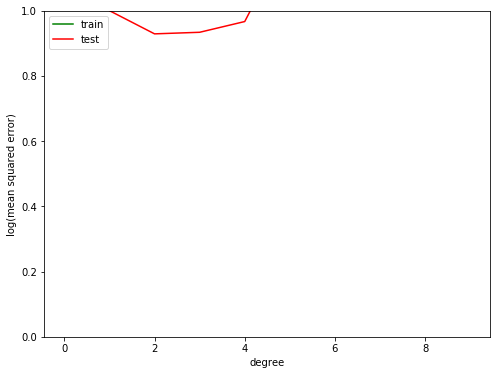

In [662]:
from sklearn.metrics import mean_squared_error

X = pitchdf[['Age']]
y = pitchdf['log_salary']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)





# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 1e0))
plt.ylabel('log(mean squared error)')
plt.xlabel('degree')
plt.legend(loc='upper left')

In [663]:
pitchdf['age_sqrd'] = pitchdf['Age'] ** 2

In [664]:
# Define the model
lm5 = smf.ols('log_salary ~ Age + age_sqrd + GS + SV + BB', data=pitchdf)

# Fit the model
fit5 = lm5.fit()
# Print summary statistics of the model's performance
fit5.summary()
#As we can see this is infact a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     60.56
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           7.72e-40
Time:                        11:53:54   Log-Likelihood:                -271.45
No. Observations:                 232   AIC:                             554.9
Df Residuals:                     226   BIC:                             575.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.6408      2.397     -1.519      0.130      -8.365       1.083
Age            1.0357      0.157      6.584      0.000       0.726       1.346
age_sqrd      -0.0141      0.003     -5.490      0.000      -0.019      -0.009
GS             0.0654      0.008      7.751      0.000       0.049       0.082
SV             0.0268      0.006      4.689      0.000       0.016       0.038
BB            -0.0176      0.006     -2.951      0.004      -0.029      -0.006
==============================================================================
Omnibus:                        3.847   Durbin-Watson:                   1.094
Prob(Omnibus):                  0.146   Jarque-Bera (JB):                3.576
Skew:                          -0.239   Prob(JB):                        0.167
Kurtosis:                       2.625   Cond. No.                     4.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [665]:
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.scatter(X, y, s=100)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((10, 20))
    ax.set_xlim((0, 20))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right',frameon=True)

x_plot = np.linspace(0, 15, 100)

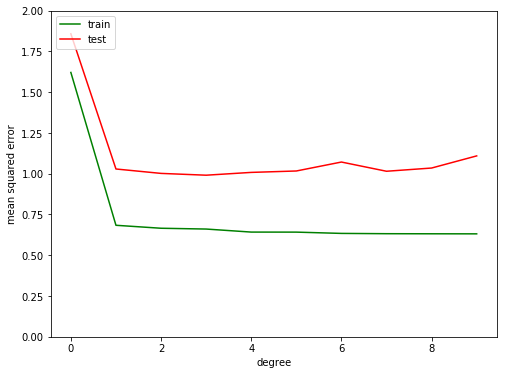

In [666]:
X = batdf[['Age']]
y = batdf['log_salary']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)





# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 2))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')

In [668]:
batdf['age_sqrd'] = batdf['Age'] ** 2
batdf['age_cube'] = batdf['Age'] ** 3
batdf['age_quad'] = batdf['Age'] ** 4

In [669]:
# Define the model
lm6 = smf.ols('log_salary ~ Age + age_sqrd + age_cube + age_quad + G + PA + RBI + SO', data=batdf)

# Fit the model
fit6 = lm6.fit()
# Print summary statistics of the model's performance
fit6.summary()
#again we can see that this is a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     66.00
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           2.76e-60
Time:                        11:54:19   Log-Likelihood:                -347.23
No. Observations:                 292   AIC:                             712.5
Df Residuals:                     283   BIC:                             745.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    224.6299     89.508      2.510      0.013      48.443     400.817
Age          -29.1550     12.209     -2.388      0.018     -53.187      -5.123
age_sqrd       1.4661      0.619      2.370      0.018       0.249       2.684
age_cube      -0.0319      0.014     -2.311      0.022      -0.059      -0.005
age_quad       0.0003      0.000      2.231      0.026       3e-05       0.000
G             -0.0231      0.004     -5.225      0.000      -0.032      -0.014
PA             0.0071      0.001      7.415      0.000       0.005       0.009
RBI            0.0062      0.003      1.949      0.052   -6.15e-05       0.012
SO            -0.0062      0.002     -3.575      0.000      -0.010      -0.003
==============================================================================
Omnibus:                        1.797   Durbin-Watson:                   1.167
Prob(Omnibus):                  0.407   Jarque-Bera (JB):                1.652
Skew:                           0.001   Prob(JB):                        0.438
Kurtosis:                       3.368   Cond. No.                     1.64e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

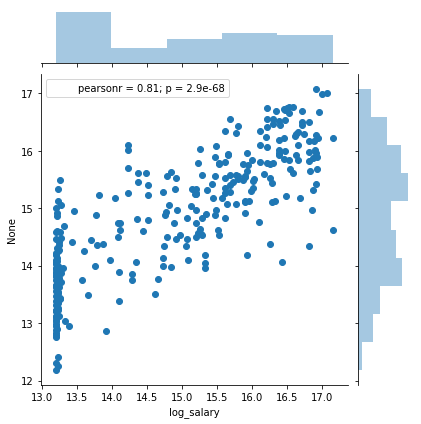

In [672]:
x = batdf.drop(['Name','BB','Salary','log_salary','SLG','OBP','SB','OPS', 'H',
       '2B', '3B', 'HR', 'CS', 'TB','BA', 'GDP', 'HBP', 'OPS+','SH', 'SF', 'IBB'],1)
y = batdf['log_salary']

y_predicted = fit6.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
#plt.title('Predictions vs. Actual outcome')
#plt.xlabel('Actual outcome')
#plt.ylabel('Predicted outcome')

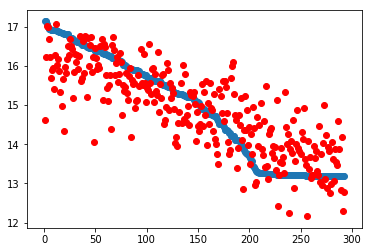

In [673]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')

(array([ 91.,   7.,   9.,   6.,   5.,   4.,   2.,   9.,   6.,   2.,   3.,
          3.,   9.,   6.,   4.,   1.,   3.,   7.,   1.,   7.,   3.,   4.,
          1.,   3.,   3.,   0.,   2.,   8.,   2.,   1.,   3.,   1.,   0.,
          1.,   3.,   0.,   1.,   6.,   0.,   3.,   2.,   3.,   1.,   1.,
          0.,   6.,   0.,   1.,   3.,   3.,   1.,   1.,   3.,   1.,   0.,
          2.,   0.,   3.,   0.,   2.,   1.,   1.,   0.,   3.,   0.,   1.,
          0.,   0.,   0.,   0.,   5.,   1.,   0.,   1.,   2.,   0.,   2.,
          2.,   3.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]), array([   535000.  ,    811316.67,   1087633.34,   1363950.01,
          1640266.68,   1916583.35,   2192900.02,   2469216.69,
          2745533.36,   3021850.03,   3298166.7 ,   3574483.37,
          3850800.04,   4127116.71,   4403433.38,   4679750.05,
          4956066.72,   5232383.39,   5508700.06,   5785016.73,

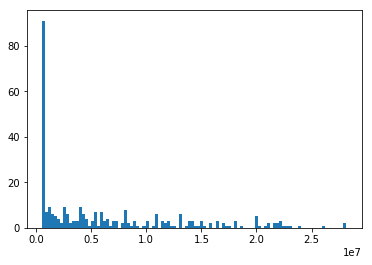

In [674]:
#lets try and remove our lowest earners from the data to see if we can get a better fit.
plt.hist(batdf['Salary'], bins = 100)

What this tells us is that there are 85 players making less than $600000.  These players are most likely rookies and have yet to sign a major contract and therefore should not be considered in this model.

(array([ 66.,  16.,   3.,   1.,   1.,   1.,   1.,   0.,   0.,   1.,   1.,
          1.,   1.,   0.,   2.,   2.,   0.,   1.,   1.,   1.,   0.,   1.,
          2.,   4.,   0.,   0.,   4.,   2.,   0.,   4.,   0.,   1.,   1.,
          3.,   0.,   1.,   1.,   0.,   3.,   3.,   3.,   2.,   1.,   4.,
          1.,   0.,   0.,   4.,   1.,   1.,   7.,   4.,   4.,   3.,   2.,
          0.,   2.,   4.,   4.,   1.,   7.,   1.,   2.,   5.,   3.,   3.,
          0.,   2.,   7.,   3.,   2.,   3.,   0.,   4.,   0.,   2.,   5.,
          5.,   4.,   1.,   6.,   1.,   6.,   2.,   4.,   2.,   3.,   3.,
          4.,   1.,   0.,   6.,   3.,   6.,   4.,   1.,   0.,   1.,   0.,
          2.]), array([ 13.19002203,  13.2296583 ,  13.26929458,  13.30893086,
         13.34856714,  13.38820342,  13.42783969,  13.46747597,
         13.50711225,  13.54674853,  13.5863848 ,  13.62602108,
         13.66565736,  13.70529364,  13.74492992,  13.78456619,
         13.82420247,  13.86383875,  13.90347503,  13.94311131,

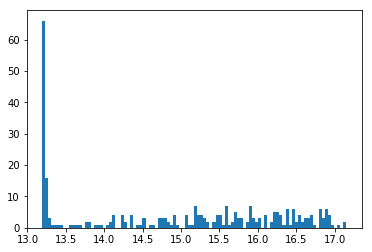

In [675]:
#lets try and remove our lowest earners from the data to see if we can get a better fit.
plt.hist(batdf['log_salary'], bins = 100)

In [676]:
batdf2 = batdf[batdf['Salary'] > 560000]

In [677]:
len(batdf) - len(batdf2)

70

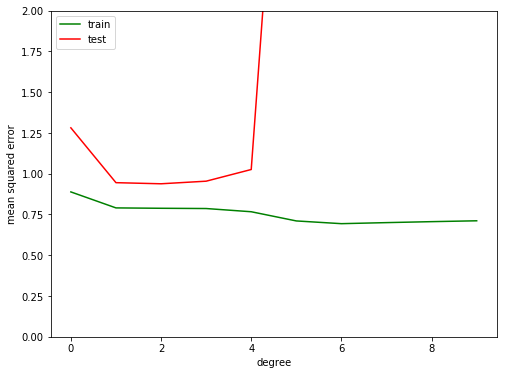

In [678]:
X = batdf2[['Age']]
y = batdf2['log_salary']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)





# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 2))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')

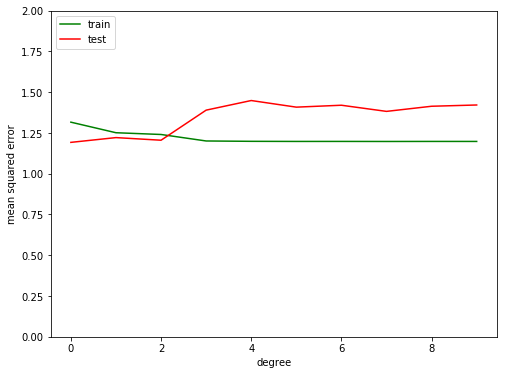

In [679]:
X = batdf2[['G']]
y = batdf2['log_salary']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)





# Step through degrees from 0 to 9 and store the training and test (generalization) error.
train_error = np.empty(10)
test_error = np.empty(10)
for degree in range(10):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X_train, y_train)
    train_error[degree] = mean_squared_error(y_train, est.predict(X_train))
    test_error[degree] = mean_squared_error(y_test, est.predict(X_test))

# Plot the training and test errors against degree
plt.figure(figsize=(8,6))
plt.plot(np.arange(10), train_error, color='green', label='train')
plt.plot(np.arange(10), test_error, color='red', label='test')
plt.ylim((0.0, 2))
plt.ylabel('mean squared error')
plt.xlabel('degree')
plt.legend(loc='upper left')

In [680]:
batdf2['G_sqrd'] = batdf2['G'] ** 2

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [681]:
batdf2.corr()

,Salary,Age,G,PA,AB,R,H,2B,3B,HR,...,GDP,HBP,SH,SF,IBB,log_salary,age_sqrd,age_cube,age_quad,G_sqrd
Salary,1.000000,0.511094,0.076473,0.190269,0.169998,0.149255,0.159176,0.114003,-0.089995,0.121286,...,0.264253,-0.040623,-0.144792,0.132713,0.186137,0.892538,0.511196,0.508253,0.502301,0.084645
Age,0.511094,1.000000,-0.168035,-0.187990,-0.202882,-0.247368,-0.247870,-0.227589,-0.220232,-0.184772,...,-0.017127,-0.002451,-0.040166,-0.025167,-0.178757,0.541449,0.997426,0.989694,0.976932,-0.169473
G,0.076473,-0.168035,1.000000,0.926238,0.919103,0.809556,0.835755,0.703864,0.320393,0.559266,...,0.497939,0.244625,0.013581,0.379882,0.362865,0.099225,-0.161349,-0.154287,-0.146988,0.994669
PA,0.190269,-0.187990,0.926238,1.000000,0.989690,0.898744,0.929197,0.768923,0.359592,0.616279,...,0.535843,0.255979,-0.063681,0.406735,0.394074,0.210247,-0.179235,-0.169999,-0.160476,0.933759
AB,0.169998,-0.202882,0.919103,0.989690,1.000000,0.870871,0.941591,0.767306,0.373852,0.575897,...,0.555736,0.209459,-0.038371,0.389099,0.339985,0.192992,-0.193462,-0.183431,-0.172996,0.927222
R,0.149255,-0.247368,0.809556,0.898744,0.870871,1.000000,0.883785,0.739178,0.432860,0.680667,...,0.402462,0.266048,-0.086990,0.288008,0.418416,0.182082,-0.239450,-0.230666,-0.221193,0.818128
H,0.159176,-0.247870,0.835755,0.929197,0.941591,0.883785,1.000000,0.808369,0.410374,0.541085,...,0.558470,0.203307,-0.048467,0.374207,0.383675,0.187534,-0.241664,-0.234362,-0.226137,0.845598
2B,0.114003,-0.227589,0.703864,0.768923,0.767306,0.739178,0.808369,1.000000,0.262197,0.456229,...,0.418659,0.161209,-0.085894,0.374964,0.395515,0.133352,-0.219959,-0.211420,-0.202103,0.710247
3B,-0.089995,-0.220232,0.320393,0.359592,0.373852,0.432860,0.410374,0.262197,1.000000,0.016880,...,-0.047342,0.096671,0.199442,0.002652,0.117665,-0.058798,-0.219629,-0.217649,-0.214351,0.321583
HR,0.121286,-0.184772,0.559266,0.616279,0.575897,0.680667,0.541085,0.456229,0.016880,1.000000,...,0.377670,0.162767,-0.285034,0.261390,0.441622,0.119600,-0.178914,-0.172385,-0.165312,0.568948


In [682]:
# Define the model
lm7 = smf.ols('log_salary ~ Age + age_sqrd + age_cube + age_quad + G + G_sqrd + PA + RBI + SO', data=batdf2)

# Fit the model
fit7 = lm7.fit()
# Print summary statistics of the model's performance
fit7.summary()
#again we can see that this is a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     25.87
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           9.31e-30
Time:                        11:54:52   Log-Likelihood:                -253.08
No. Observations:                 222   AIC:                             526.2
Df Residuals:                     212   BIC:                             560.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     75.1594    143.716      0.523      0.602    -208.137     358.456
Age           -9.8541     19.032     -0.518      0.605     -47.370      27.662
age_sqrd       0.5428      0.938      0.579      0.563      -1.305       2.391
age_cube      -0.0125      0.020     -0.615      0.539      -0.053       0.028
age_quad       0.0001      0.000      0.636      0.526      -0.000       0.000
G             -0.0125      0.020     -0.624      0.533      -0.052       0.027
G_sqrd     -7.223e-05   8.73e-05     -0.827      0.409      -0.000    9.99e-05
PA             0.0078      0.001      6.563      0.000       0.005       0.010
RBI            0.0077      0.003      2.260      0.025       0.001       0.014
SO            -0.0053      0.002     -2.704      0.007      -0.009      -0.001
==============================================================================
Omnibus:                        4.751   Durbin-Watson:                   0.903
Prob(Omnibus):                  0.093   Jarque-Bera (JB):                4.472
Skew:                          -0.278   Prob(JB):                        0.107
Kurtosis:                       3.418   Cond. No.                     2.65e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

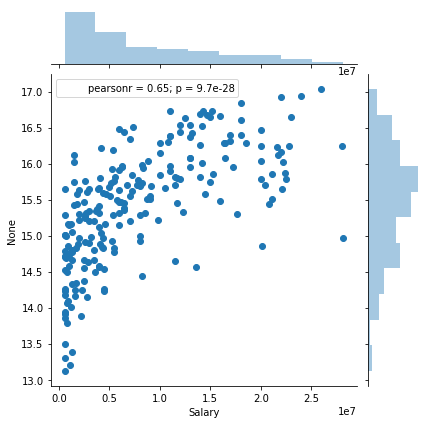

In [685]:
x = batdf2.drop(['Name','BB','log_salary','SLG','OBP','SB','OPS', 'H',
       '2B', '3B', 'HR', 'CS', 'TB','BA', 'GDP', 'HBP', 'OPS+','SH', 'SF', 'IBB'],1)
y = batdf2['Salary']

y_predicted = fit7.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
#plt.title('Predictions vs. Actual outcome')
#plt.xlabel('Actual outcome')
#plt.ylabel('Predicted outcome')

0.30667493212


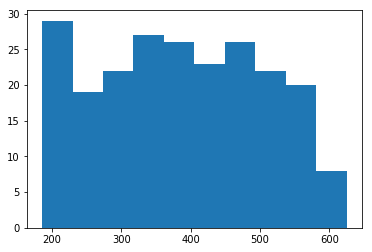

In [686]:
from scipy import stats

lamb=stats.boxcox_normmax(batdf2.Salary, brack=(-1.9, 1.9))
print(lamb)
y_t=(np.power(batdf2.Salary,lamb)-1)/lamb

plt.hist(y_t);

In [687]:
batdf3 = batdf2
batdf3.loc[:,'y_t'] = y_t


lm8 = smf.ols('y_t ~ Age + age_sqrd  + G + PA + RBI + SO', data=batdf2)

# Fit the model
fit8 = lm8.fit()
# Print summary statistics of the model's performance
fit8.summary()
#again we can see that this is a better fit.

/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/gilliangoodman/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    y_t   R-squared:                       0.516
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     38.26
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           1.95e-31
Time:                        11:55:26   Log-Likelihood:                -1298.1
No. Observations:                 222   AIC:                             2610.
Df Residuals:                     215   BIC:                             2634.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1211.3005    356.576     -3.397      0.001   -1914.133    -508.468
Age           85.5504     23.455      3.647      0.000      39.319     131.782
age_sqrd      -1.0629      0.386     -2.752      0.006      -1.824      -0.302
G             -3.2745      0.604     -5.421      0.000      -4.465      -2.084
PA             0.8319      0.126      6.608      0.000       0.584       1.080
RBI            0.8973      0.371      2.417      0.016       0.166       1.629
SO            -0.5257      0.213     -2.466      0.014      -0.946      -0.106
==============================================================================
Omnibus:                        2.958   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.228   Jarque-Bera (JB):                2.796
Skew:                           0.150   Prob(JB):                        0.247
Kurtosis:                       3.461   Cond. No.                     6.63e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.63e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [688]:
lm9 = smf.ols('y_t ~ Age + age_sqrd + BB  + G + PA + RBI + SO + age_cube + SLG + OBP + SB + OPS + H + HR + CS + TB + BA + GDP + HBP + OPS+ + SH + SF + IBB', data=batdf2)

# Fit the model
fit9 = lm9.fit()
# Print summary statistics of the model's performance
fit9.summary()
#again we can see that this is a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    y_t   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     11.74
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           1.82e-25
Time:                        11:55:26   Log-Likelihood:                -1286.4
No. Observations:                 222   AIC:                             2619.
Df Residuals:                     199   BIC:                             2697.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2085.4304   2406.403     -0.867      0.387   -6830.753    2659.892
Age          156.4071    236.444      0.661      0.509    -309.849     622.664
age_sqrd      -3.1868      7.742     -0.412      0.681     -18.454      12.080
BB            -1.2447      1.403     -0.887      0.376      -4.011       1.521
G             -3.2369      0.638     -5.077      0.000      -4.494      -1.980
PA             1.1136      0.454      2.453      0.015       0.218       2.009
RBI            0.6394      0.708      0.903      0.368      -0.757       2.036
SO            -0.5618      0.282     -1.991      0.048      -1.118      -0.005
age_cube       0.0207      0.084      0.247      0.805      -0.144       0.186
SLG        -3696.8593   1.33e+04     -0.278      0.781   -2.99e+04    2.25e+04
OBP        -2596.9315   1.33e+04     -0.195      0.846   -2.89e+04    2.37e+04
SB             0.6594      1.110      0.594      0.553      -1.530       2.849
OPS         3486.5746   1.33e+04      0.262      0.794   -2.27e+04    2.97e+04
H             -0.5651      2.408     -0.235      0.815      -5.314       4.183
HR             2.8789      3.149      0.914      0.362      -3.331       9.088
CS             3.4695      3.774      0.919      0.359      -3.973      10.912
TB            -0.5138      1.375     -0.374      0.709      -3.225       2.197
BA          -353.7619   1073.353     -0.330      0.742   -2470.368    1762.844
GDP            2.7989      1.548      1.809      0.072      -0.253       5.851
HBP           -4.3573      2.054     -2.121      0.035      -8.408      -0.307
SH            -3.8590      4.694     -0.822      0.412     -13.115       5.397
SF             1.6285      3.323      0.490      0.625      -4.925       8.182
IBB            5.4017      2.162      2.499      0.013       1.139       9.664
==============================================================================
Omnibus:                        2.373   Durbin-Watson:                   0.969
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                2.163
Skew:                           0.113   Prob(JB):                        0.339
Kurtosis:                       3.428   Cond. No.                     1.20e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

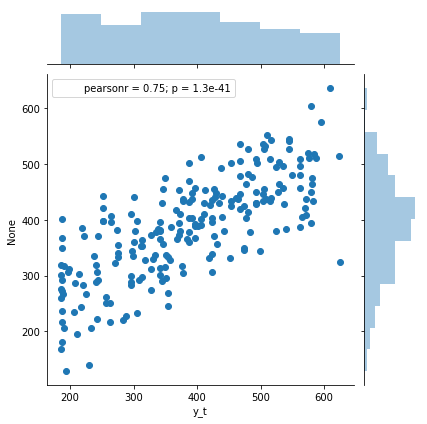

In [691]:
x = batdf3.drop(['Name','log_salary', 'Salary',
       '2B', '3B'],1)
y = batdf3['y_t']

y_predicted = fit9.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
#plt.title('Predictions vs. Actual outcome')
#plt.xlabel('Actual outcome')
#plt.ylabel('Predicted outcome')

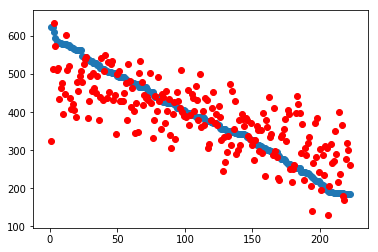

In [692]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')

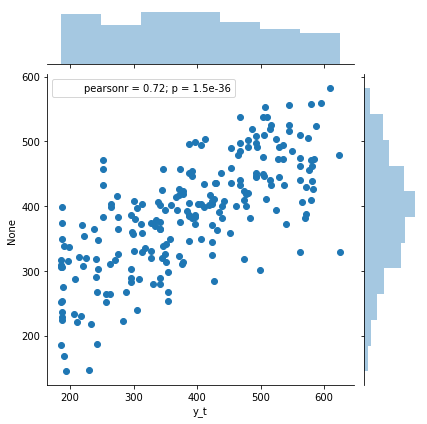

In [695]:
x = batdf3.drop(['Name','log_salary','age_cube', 'Salary', 'SLG','OBP','SB','OPS', 'H',
       '2B', '3B', 'HR', 'CS', 'TB','BA', 'GDP', 'HBP', 'OPS+','SH', 'SF', 'IBB'],1)
y = batdf3['y_t']

y_predicted = fit8.predict(x)
y_predicted

predictdf = pd.DataFrame(y_predicted,y)

sns.jointplot(y, y_predicted)
#plt.title('Predictions vs. Actual outcome')
#plt.xlabel('Actual outcome')
#plt.ylabel('Predicted outcome')

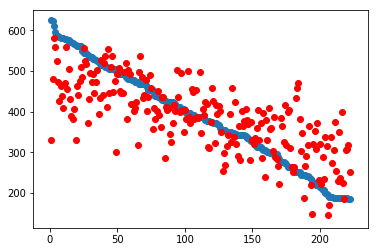

In [696]:
plt.scatter(range(1,len(y_predicted)+1),y)
plt.scatter(range(1,len(y_predicted)+1), y_predicted, color='red')

In [697]:
batdf2.columns

Index(['Name', 'Salary', 'Age', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR',
       'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+', 'TB',
       'GDP', 'HBP', 'SH', 'SF', 'IBB', 'log_salary', 'age_sqrd', 'age_cube',
       'age_quad', 'G_sqrd', 'y_t'],
      dtype='object')

In [730]:

est=LinearRegression()
x = batdf2.drop(['Salary', 'log_salary','Name'],1)
kf=KFold(n=len(x),n_folds=5,shuffle=True)

all_scores=[]

# Instead of using cross_val_score, let's use sklearn.cross_validation.KFold; this will allow
# us to 'manipulate' our training set, 

# get indices of corresponding train & test
for train,test in kf:
    x_train=x.iloc[train]
    y_train=y.iloc[train]
    x_test=x.iloc[test]
    y_test=y.iloc[test]
    pvals=[]
    sig_cols=[]
    
    for feature in x_train.columns:
        pval=f_select.f_regression(x_train[[feature]],y_train)
        if pval[1][0]<.05: 
            sig_cols.append(feature)
            pvals.append(pval[1][0])
            
    est.fit(x_train[sig_cols],y_train)
    r_2=est.score(x_test[sig_cols],y_test)
    all_scores.append(r_2)
        
np.mean(all_scores)

    

0.91246689970338812

In [699]:
sig_cols

['Age',
 'PA',
 'AB',
 'RBI',
 'BB',
 'GDP',
 'SH',
 'age_sqrd',
 'age_cube',
 'age_quad']

In [700]:
# Define the model
lm10 = smf.ols('log_salary ~ Age + age_sqrd + age_cube + G + PA + RBI + SO', data=batdf)

# Fit the model
fit10 = lm10.fit()
# Print summary statistics of the model's performance
fit10.summary()
#again we can see that this is a better fit.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_salary   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     73.68
Date:                Thu, 01 Feb 2018   Prob (F-statistic):           3.55e-60
Time:                        11:56:06   Log-Likelihood:                -349.77
No. Observations:                 292   AIC:                             715.5
Df Residuals:                     284   BIC:                             745.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.6741     14.903      1.857      0.064      -1.661      57.009
Age           -2.1238      1.520     -1.397      0.163      -5.115       0.868
age_sqrd       0.0906      0.051      1.770      0.078      -0.010       0.191
age_cube      -0.0011      0.001     -1.982      0.048      -0.002   -7.62e-06
G             -0.0228      0.004     -5.120      0.000      -0.032      -0.014
PA             0.0070      0.001      7.297      0.000       0.005       0.009
RBI            0.0062      0.003      1.931      0.054      -0.000       0.012
SO            -0.0064      0.002     -3.654      0.000      -0.010      -0.003
==============================================================================
Omnibus:                        0.649   Durbin-Watson:                   1.138
Prob(Omnibus):                  0.723   Jarque-Bera (JB):                0.400
Skew:                           0.007   Prob(JB):                        0.819
Kurtosis:                       3.181   Cond. No.                     8.47e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

ValueError: Found input variables with inconsistent numbers of samples: [44, 178]

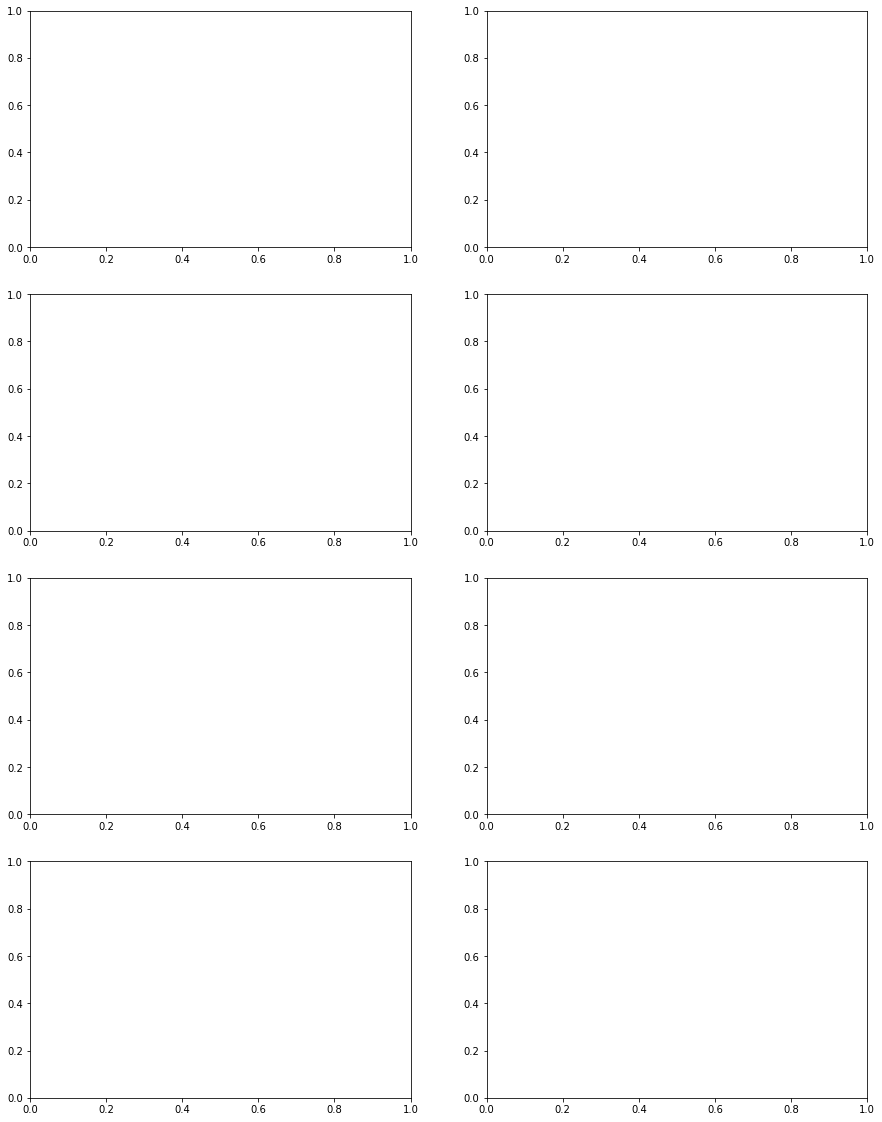

In [701]:
from sklearn.linear_model import Ridge

fig, ax_rows = plt.subplots(4, 2, figsize=(15, 20))

# A helper function to plot the absolute value of the coefficients on the right-hand column plot
def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((1, 9))

# Try out 4 different values of the RidgeRegression parameter alpha and watch how the resulting models change
# With higher values of alpha, more complex (more wiggly) models will be more punished and thus less likely
degree = 3
alphas = [0.0, 1e-8, 1e-5, 1e-1]
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X_train, y_train)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)

plt.tight_layout()